# LDA for Topic Modeling
1. Load News from pickle file.
2. Preprocess text.
3. Apply different number of topics and choose one with highest Coherence Score.
4. Visualize the result of different latent topics using pyLDAvis.

In [1]:
# Reference: https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/. 
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
# conda install -c conda-forge spacy
# python -m spacy download en
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

import nltk; nltk.download('stopwords')

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

/home/cya96/.local/lib/python3.7/site-packages/nltk/decorators.py:68: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  regargs, varargs, varkwargs, defaults, formatvalue=lambda value: ""
[nltk_data] Downloading package stopwords to /home/cya96/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Load news from pickle file.
import pandas as pd
import numpy as np
data = pd.read_pickle('../../../Data/ProcessedNews.pkl')
data.head()

,headline,date,content,tokens,tokens_remove_stopwords,content_length,le_content
0,Last-minute Christmas rush lifts UK retail sales,2017-01-10 00:00:00,Industry figures add to signs that the economy...,"[industry, figures, add, to, signs, that, the,...","[industry, figures, add, signs, economy, ended...",385.0,"[industry, figure, add, sign, economy, ended, ..."
1,Guarantee minimum wage for gig economy workers...,2017-01-31 00:00:00,Labour MP wants government to set up national ...,"[labour, mp, wants, government, to, set, up, n...","[labour, mp, wants, government, set, national,...",325.0,"[labour, mp, want, government, set, national, ..."
2,,2017-01-27 00:00:00,IG traders expect US markets to open higher US...,"[ig, traders, expect, us, markets, to, open, h...","[ig, traders, expect, us, markets, open, highe...",23.0,"[ig, trader, expect, u, market, open, higher, ..."
3,Why the UK economy could fare better in 2017 t...,2017-01-01 00:00:00,"From house prices to exports, there are reason...","[from, house, prices, to, exports, there, are,...","[house, prices, exports, reasons, cheerful, ye...",667.0,"[house, price, export, reason, cheerful, year,..."
4,,2017-02-08 00:00:00,"On the US oil stock numbers, David Morrison, s...","[on, the, us, oil, stock, numbers, david, morr...","[us, oil, stock, numbers, david, morrison, sen...",235.0,"[u, oil, stock, number, david, morrison, senio..."


In [3]:
# Data too large. Sample part of news for visulaization.
data = data.sample(frac=0.2, random_state=1)

In [4]:
# Tokenize news using gensim package.
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

data_words = list(sent_to_words(data['content']))

print(data_words[:1])

[['those', 'housing', 'finance', 'figures', 'are', 'not', 'great', 'news', 'for', 'australia', 'banks', 'which', 'have', 'built', 'their', 'huge', 'profitability', 'in', 'recent', 'years', 'on', 'some', 'heroic', 'mortgage', 'lending', 'the', 'financial', 'sector', 'of', 'the', 'asx', 'is', 'down', 'today', 'in', 'market', 'off', 'overall']]


In [5]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['those', 'housing', 'finance', 'figures', 'are', 'not', 'great', 'news', 'for', 'australia', 'banks', 'which', 'have', 'built', 'their', 'huge', 'profitability', 'in', 'recent', 'years', 'on', 'some', 'heroic', 'mortgage', 'lending', 'the', 'financial', 'sector', 'of', 'the', 'asx', 'is', 'down', 'today', 'in', 'market', 'off', 'overall']


In [6]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [8]:
# Remove Stop Words
# Run in terminal or command prompt

from nltk.corpus import stopwords
stop_words = stopwords.words('english')
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['housing', 'finance', 'figure', 'great', 'news', 'australia', 'bank', 'build', 'huge', 'profitability', 'recent', 'year', 'heroic', 'mortgage', 'lend', 'financial', 'sector', 'asx', 'today', 'market', 'overall']]


In [9]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1)]]


In [10]:
# Build LDA model
num_topics = 15
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [25]:
# Save the model.
lda_model.save('lda_model-{}'.format(num_topics))

In [11]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.062*"say" + 0.015*"would" + 0.008*"also" + 0.007*"include" + 0.007*"take" '
  '+ 0.007*"official" + 0.006*"group" + 0.006*"year" + 0.006*"law" + '
  '0.006*"could"'),
 (1,
  '0.051*"european" + 0.045*"britain" + 0.040*"europe" + 0.034*"brexit" + '
  '0.031*"european_union" + 0.031*"germany" + 0.026*"german" + 0.025*"france" '
  '+ 0.024*"british" + 0.023*"uk"'),
 (2,
  '0.032*"car" + 0.026*"russian" + 0.025*"oil" + 0.021*"energy" + '
  '0.020*"russia" + 0.014*"tesla" + 0.012*"climate_change" + 0.012*"driver" + '
  '0.011*"production" + 0.011*"vehicle"'),
 (3,
  '0.133*"bank" + 0.043*"financial" + 0.036*"debt" + 0.031*"loan" + '
  '0.025*"crisis" + 0.024*"government" + 0.024*"bond" + 0.022*"central_bank" + '
  '0.020*"greece" + 0.017*"italy"'),
 (4,
  '0.061*"food" + 0.043*"restaurant" + 0.032*"cook" + 0.032*"plastic" + '
  '0.026*"eat" + 0.021*"farm" + 0.018*"flavor" + 0.014*"fish" + 0.013*"rice" + '
  '0.013*"serve"'),
 (5,
  '0.028*"say" + 0.010*"go" + 0.010*"year" + 0.009*

In [12]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -11.070454061063929

Coherence Score:  0.5410023858912039


In [13]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/home/cya96/.local/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.212121 -0.051801       1        1  21.541708
10    -0.187115  0.035615       2        1  16.612911
0     -0.185571  0.045231       3        1  15.267002
7     -0.136122  0.041589       4        1  11.087704
6     -0.187014 -0.091298       5        1   8.592156
14    -0.073009  0.133235       6        1   6.583494
13    -0.025299 -0.094454       7        1   4.211910
8     -0.019339 -0.152719       8        1   3.424922
9      0.015019  0.175625       9        1   3.092358
11     0.046363  0.200841      10        1   2.648869
2      0.055041 -0.172141      11        1   2.190076
12     0.125503 -0.212550      12        1   1.514830
1      0.215843  0.201960      13        1   1.416357
3      0.261946  0.097010      14        1   1.235867
4      0.305875 -0.156145      15        1   0.579830, topic_info=     Category           Freq        Term          Total  loglift  logprob
169   Default  124408.000000         say  124408.000000  30.0000  30.0000
609   Default   38597.000000     company   38597.000000  29.0000  29.0000
1010  Default   24393.000000       trump   24393.000000  28.0000  28.0000
2     Default   12494.000000        bank   12494.000000  27.0000  27.0000
245   Default   13310.000000       china   13310.000000  26.0000  26.0000
535   Default   38115.000000         new   38115.000000  25.0000  25.0000
12    Default   24059.000000      market   24059.000000  24.0000  24.0000
312   Default   18436.000000  government   18436.000000  23.0000  23.0000
249   Default   11763.000000        city   11763.000000  22.0000  22.0000
6     Default   10493.000000   financial   10493.000000  21.0000  21.0000
138   Default   24689.000000     percent   24689.000000  20.0000  20.0000
259   Default   17130.000000     country   17130.000000  19.0000  19.0000
197   Default   10483.000000       trade   10483.000000  18.0000  18.0000
182   Default   13775.000000       stock   13775.000000  17.0000  17.0000
542   Default   15459.000000   president   15459.000000  16.0000  16.0000
421   Default    6840.000000      school    6840.000000  15.0000  15.0000
498   Default   14999.000000    american   14999.000000  14.0000  14.0000
550   Default    9192.000000  republican    9192.000000  13.0000  13.0000
213   Default   22090.000000        work   22090.000000  12.0000  12.0000
48    Default    6458.000000       child    6458.000000  11.0000  11.0000
444   Default   16428.000000       state   16428.000000  10.0000  10.0000
560   Default    7598.000000       story    7598.000000   9.0000   9.0000
246   Default    6360.000000     chinese    6360.000000   8.0000   8.0000
322   Default   15977.000000        high   15977.000000   7.0000   7.0000
20    Default   49126.000000        year   49126.000000   6.0000   6.0000
196   Default   29065.000000        time   29065.000000   5.0000   5.0000
299   Default    8251.000000      family    8251.000000   4.0000   4.0000
1085  Default   10296.000000        deal   10296.000000   3.0000   3.0000
635   Default    5927.000000    european    5927.000000   2.0000   2.0000
216   Default   38161.000000       would   38161.000000   1.0000   1.0000
...       ...            ...         ...            ...      ...      ...
4584  Topic15     186.041718        pork     187.131287   5.1444  -5.2674
5863  Topic15     169.767014         fry     170.856583   5.1438  -5.3590
3052  Topic15     167.444931          el     168.534515   5.1437  -5.3728
5888  Topic15     163.637970        milk     164.727554   5.1436  -5.3958
3089  Topic15     162.336578         los     163.426163   5.1435  -5.4037
4877  Topic15     159.032059    sandwich     160.121643   5.1434  -5.4243
4455  Topic15     157.643707         que     158.733276   5.1433  -5.4331
5816  Topic15     142.953552        beef     144.043137   5.1426  -5.5309
525   Topic15     135.627686      harlem     136.717270   5.1422  -5.5835
5840 

In [16]:
# Save the LDA result as an HTML file.
pyLDAvis.save_html(vis, 'lda-{}.html'.format(num_topics))

In [17]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = 'mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [18]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(7,
  [('bank', 0.034627264061010486),
   ('tax', 0.026795042897998094),
   ('financial', 0.019607244995233555),
   ('money', 0.01861582459485224),
   ('pay', 0.015687321258341276),
   ('government', 0.013860819828408007),
   ('debt', 0.01340324118207817),
   ('plan', 0.011195424213536701),
   ('year', 0.010825548141086749),
   ('cut', 0.00986463298379409)]),
 (19,
  [('company', 0.032698077747370505),
   ('facebook', 0.02135250090672294),
   ('amazon', 0.01536153516436414),
   ('apple', 0.014665831382505193),
   ('technology', 0.014355896996274193),
   ('tech', 0.013983316297932672),
   ('datum', 0.013126050974315013),
   ('service', 0.0120346862738633),
   ('internet', 0.010343235846879224),
   ('user', 0.009030960466879885)]),
 (0,
  [('car', 0.020309987780564667),
   ('company', 0.0121165348253907),
   ('energy', 0.011126117435204837),
   ('year', 0.010860291122687419),
   ('industry', 0.010345788582331126),
   ('make', 0.008090552447102708),
   ('vehicle', 0.00766180033013913),
 

In [19]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [20]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

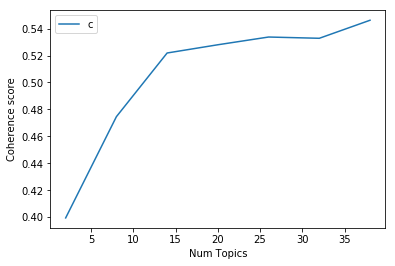

In [21]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [22]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3994
Num Topics = 8  has Coherence Value of 0.4746
Num Topics = 14  has Coherence Value of 0.5219
Num Topics = 20  has Coherence Value of 0.528
Num Topics = 26  has Coherence Value of 0.5338
Num Topics = 32  has Coherence Value of 0.5328
Num Topics = 38  has Coherence Value of 0.5462


In [34]:
num_topics = 38
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [35]:
# Visualize the model with highest coherence score.
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/home/cya96/.local/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.249880 -0.129576       1        1  15.071617
11     0.250377 -0.026491       2        1  12.266595
34     0.243964  0.093351       3        1   9.019594
36     0.212989 -0.093341       4        1   8.335738
14     0.188183 -0.116364       5        1   7.985023
24     0.239049  0.043768       6        1   7.529024
37     0.160750 -0.026589       7        1   3.947217
13     0.089179 -0.163909       8        1   2.818868
6      0.094283 -0.108664       9        1   2.761216
27     0.091146 -0.019563      10        1   2.729728
18     0.103276 -0.081628      11        1   2.397156
22     0.046034 -0.132040      12        1   2.205489
10     0.093563  0.236945      13        1   2.135530
23     0.129186  0.059358      14        1   1.995270
3      0.081528 -0.086366      15        1   1.657244
16     0.012150 -0.040575      16        1   1.579214
17     0.026330  0.082894      17        1   1.540616
26     0.063322  0.273682      18        1   1.420584
25     0.051068  0.244569      19        1   1.335235
15    -0.021190 -0.089458      20        1   1.310325
19     0.044152  0.251953      21        1   1.240058
2     -0.006048 -0.062677      22        1   1.104903
12    -0.022622 -0.061390      23        1   0.994447
1     -0.050890 -0.025630      24        1   0.908537
20    -0.058006  0.060376      25        1   0.897011
35    -0.027669 -0.011417      26        1   0.868199
28    -0.083146  0.056147      27        1   0.630482
29    -0.124484 -0.015325      28        1   0.510775
31    -0.120280  0.096846      29        1   0.506019
0     -0.139499 -0.012833      30        1   0.506009
8     -0.113326 -0.018735      31        1   0.482522
21    -0.123086 -0.089896      32        1   0.455159
33    -0.179292  0.005893      33        1   0.365724
32    -0.248877 -0.014819      34        1   0.176578
9     -0.256222 -0.018200      35        1   0.150505
7     -0.268059 -0.022394      36        1   0.108358
4     -0.306630 -0.018425      37        1   0.052662
30    -0.321083 -0.019475      38        1   0.000764, topic_info=      Category           Freq                Term          Total  loglift  \
169    Default  125290.000000                 say  125290.000000  30.0000   
609    Default   38966.000000             company   38966.000000  29.0000   
1010   Default   24121.000000               trump   24121.000000  28.0000   
138    Default   23123.000000             percent   23123.000000  27.0000   
12     Default   22814.000000              market   22814.000000  26.0000   
2      Default   12026.000000                bank   12026.000000  25.0000   
535    Default   38362.000000                 new   38362.000000  24.0000   
213    Default   22213.000000                work   22213.000000  23.0000   
245    Default   13140.000000               china   13140.000000  22.0000   
216    Default   38449.000000               would   38449.000000  21.0000   
20     Default   49461.000000                year   49461.000000  20.0000   
444    Default   15990.000000               state   15990.000000  19.0000   
1413   Default   10688.000000                 job   10688.000000  18.0000   
249    Default   11444.000000                city   11444.000000  17.0000   
259    Default   17689.000000             country   17689.000000  16.0000   
182    Default   12565.000000               stock   12565.000000  15.0000   
1990   Default   13160.000000                  ms   13160.000000  14.0000   
312    Default   18679.000000          government   18679.000000  13.0000   
542    Default   15588.000000           president   15588.000000  12.0000   
6      Default   10307.000000           financial   10307.000000  11.0000   
283    Default   14167.000000             economy   14167.000000  10.0000   
57     Default   16644.000000                 day   16644.000000   9.0000   
550    Default    8728.000

In [37]:
# Save the model
lda_model.save('lda_model-best-{}'.format(num_topics))

In [36]:
# Save the LDA result as an HTML file.
pyLDAvis.save_html(vis, 'lda-{}.html'.format(num_topics))